To understand how neural nets work, it's best to start with a very small one. (I'm also going to assume some knowledge of multivariate calculus here, most importantly of partial derivatives and the meaning of the gradient vector.) So let's specify a simple prediction problem and attempt to solve it with a neural net having a small number of nodes and only one hidden layer. Suppose we want our neural net to predict each of the following outputs from the corresponding row of input. (This example comes from the book Grokking Deep Learning, by Andrew W Trask, which I highly recommend!) 

In [1]:
import numpy as np

inputs = np.array([[1,0,1],
                   [0,1,1],
                   [0,0,1],
                   [1,1,1]])

outputs = np.array([1,1,0,0])

So, for example, from [1,0,1] we'd like our neural net to predict 1; from [0,0,1] we'd like it to predict 0, etc. The first layer of the neural net (which we'll label with a zero) will have three nodes, each of which will accept one of the three input values, say, in the first row of the inputs. The second layer (which we'll label as 1), will have four nodes, and the final layer (labeled as 2) will have a single neuron, because the net needs to predict a single number. Here's a image of the network that was made using graphviz:

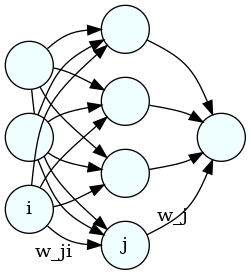

In [2]:
from IPython import display
display.Image("neural_net.png")

Each neuron in the middle will compute a weighted sum of the three inputs on the left; then the neuron on the right will compute a weighted sum of the four resulting numbers from the middle layer. Finally, we compute the squared difference between the prediction and the correct result. Each weighted sum is called an "activation", so we'll label them as a's. So, for example, the activation for node 0 (say, the top one) in the middle layer is
$$
a^{(1)}_0=\sigma(w_{00}a^{(0)}_0+w_{01}a^{(0)}_1+w_{02}a^{(0)}_2),
$$
where the superscripts are the layer numbers, the subscripts are the neuron labels, $w_{ji}$ is the weight in neuron $j$ that gets attached to the value from neuron {i}, and $\sigma$ is a "squishification" function, such as relu or the logistic function, which map the whole real line into the interval (0,1). Hence, the activations for layer 1 (the middle one) can be written succintly as
$$
a^{(1)}_{j} = \sigma(\sum_{i=0}^2 w_{ij} a^{(0)_j}).
$$
There's also normally a constant term in addition to the weighted sum, called a bias, but we're setting all those to zero for present purposes, to keep things simple.

We will also leave out the squishification function for layer 2, so its activation is
$$
a^{(2)}=\sum_{j=0}^3 w_j a^{(1)}_j.
$$
Finally, the error is just
$$
\epsilon = (a^{(2)}-y)^2,
$$
where $y$ is the correct label for the corresponding row of input data.

Initially, all the weights will be random and the neural net will produce completely wrong numbers, but we're going to adjust the weights using a procedure called gradient descent. We consider the error as a function of all the weights and calculate it's gradient vector. This vector (which will exist in a 5D space in this case because we have 5 weights) will point in the direction of greatest increase in $\epsilon$; since we're trying to decrease $\epsilon$, we'll take steps in the opposite direction, i.e., we'll adjust each weight in the direction opposite the corresponding component of the gradient vector.

First, we'll write the algorithm using numerically evaluated derivatives, which would be much too slow for use on a large neural net, but which will allow us to make sure the analytical derivatives we calculate later are correct. Also, we'll use relu as our squishification function.

In [3]:
hidden_layer = 4
weights_0_1 = 2.0*np.random.random((hidden_layer,3))-1.0
weights_1_2 = 2.0*np.random.random((1,hidden_layer))-1.0

#we'll modify the above weights later so we'll store the old values here too
weights_0_1_init = weights_0_1
weights_1_2_init = weights_1_2

def relu(x):
    return (x>0)*x

def activate_mid(weights,layer):
    return relu(np.matmul(weights,layer))

def activate(weights,layer):
    return np.matmul(weights,layer)

def error(inp,weights_0_1,weights_1_2,out):
    layer_1 = activate_mid(weights_0_1,inp)
    layer_2 = activate(weights_1_2,layer_1)
    return np.sum((layer_2-out)**2.0)

def error_derivs(layer_num,inp,out,weights_0_1,weights_1_2):
    delta_w = 0.0001
    layer_1 = activate_mid(weights_0_1,inp)
    layer_2 = activate(weights_1_2,layer_1)
    if (layer_num==1):
        derivs_1 = np.zeros((hidden_layer,3))
        weights_0_1_left  = weights_0_1
        weights_0_1_right = weights_0_1
        for i in range(weights_0_1.shape[0]):
            for j in range(weights_0_1.shape[1]):
                weights_0_1_left[i,j]=weights_0_1[i,j]-delta_w
                err_0 = error(inp,weights_0_1_left, \
                              weights_1_2,out)
                weights_0_1_left[i,j]=weights_0_1[i,j]+delta_w
                weights_0_1_right[i,j]=weights_0_1[i,j]+delta_w
                err_1 = error(inp,weights_0_1_right, \
                              weights_1_2,out)
                weights_0_1_right[i,j]=weights_0_1[i,j]-delta_w
                derivs_1[i,j] = (err_1-err_0)/(2.0*delta_w)
        return derivs_1
    elif (layer_num==2):
        derivs_2 = np.zeros((1,hidden_layer))
        weights_1_2_left  = weights_1_2
        weights_1_2_right = weights_1_2
        for i in range(weights_1_2.shape[0]):
            for j in range(weights_1_2.shape[1]):
                weights_1_2_left[i,j]=weights_1_2[i,j]-delta_w
                err_0 = error(inp,weights_0_1, \
                              weights_1_2_left,out)
                weights_1_2_left[i,j]=weights_1_2[i,j]+delta_w
                weights_1_2_right[i,j]=weights_1_2[i,j]+delta_w
                err_1 = error(inp,weights_0_1, \
                              weights_1_2_right,out)
                weights_1_2_right[i,j]=weights_1_2[i,j]-delta_w
                derivs_2[i,j] = (err_1-err_0)/(2.0*delta_w)
        return derivs_2

In [4]:
alpha = 0.1
for iter in range(60):
    err = 0.0
    for i in range(inputs.shape[0]):
        inp = inputs[i:i+1].T
        out = outputs[i]

        derivs_1 = error_derivs(1,inp,out,weights_0_1, \
                                weights_1_2)
        derivs_2 = error_derivs(2,inp,out,weights_0_1, \
                                weights_1_2)

        weights_0_1 -= alpha*derivs_1
        weights_1_2 -= alpha*derivs_2
        err += error(inp,weights_0_1,weights_1_2,out)

        layer_1 = relu(np.matmul(weights_0_1,inp))
        layer_2 = np.matmul(weights_1_2,layer_1)
        #print(layer_2,out)

    err /= inputs.shape[0]
    if (iter % 10 == 9):
        print(err)

0.014687928092963858
0.0002586911405566519
5.201032288065113e-06
1.1521188868884113e-07
2.509888068656647e-09
7.063314626310347e-11


The errors are converging nicely toward zero. Now when we feed, say, [1,0,1], into our neural net, we should get out something close to 1: 

In [5]:
inp = np.array([[1,0,1]]).T
layer_1 = activate_mid(weights_0_1,inp)
layer_2 = activate(weights_1_2,layer_1)
print(layer_2)

[[0.99997933]]


To calculate the derivatives analytically and avoid the slow loops, we take into account the functional dependencies between the error, activations, and weights while using the chain rule. The diagram below shows those interdependencies.

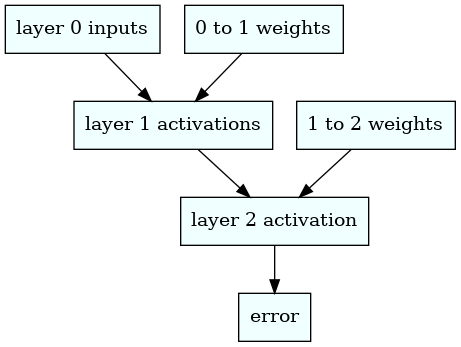

In [6]:
display.Image("chain_rule.png")

We obtain the following derivatives
$$
\frac{\partial \epsilon}{\partial w_j}=\frac{\partial \epsilon}{\partial a^{(2)}}\frac{\partial a^{(2)}}{\partial w_j}=2(a^{(2)}-y)a^{(1)}_j,
$$
and
$$
\frac{\partial \epsilon}{\partial w_{ji}}=\frac{\partial \epsilon}{\partial a^{(2)}}\sum_{k=0}^3 \frac{\partial a^{(2)}}{\partial a^{(1)}_k}\frac{\partial a^{(1)}_k}{\partial w_{ji}}=2(a^{(2)}-y)\sigma'_j w_j a^{(0)}_j.
$$
We now run the same code but implementing these derivatives.

In [7]:
def relu_deriv(x):
    return x>0

def error_derivs(layer_num,inp,out,weights_0_1,weights_1_2):
    delta_w = 0.0001
    layer_1 = activate_mid(weights_0_1,inp)
    layer_2 = activate(weights_1_2,layer_1)
    if (layer_num==1):
        derivs_1 = np.zeros((hidden_layer,3))
        weights_0_1_left  = weights_0_1
        weights_0_1_right = weights_0_1
        prefactor = 2.0*(layer_2-out)
        derivs_1  = prefactor*np.outer(relu_deriv(layer_1)* \
                                       weights_1_2.T,inp)
        return derivs_1
    elif (layer_num==2):
        derivs_2 = np.zeros((1,hidden_layer))
        weights_1_2_left  = weights_1_2
        weights_1_2_right = weights_1_2
        derivs_2 = 2.0*(layer_2-out)*layer_1.T
        return derivs_2

# we set the weights back to their initial values
weights_0_1 = weights_0_1_init
weights_1_2 = weights_1_2_init
    
alpha = 0.1
for iter in range(60):
    err = 0.0
    for i in range(inputs.shape[0]):
        inp = inputs[i:i+1].T
        out = outputs[i]

        derivs_1 = error_derivs(1,inp,out,weights_0_1, \
                                weights_1_2)
        derivs_2 = error_derivs(2,inp,out,weights_0_1, \
                                weights_1_2)

        weights_0_1 -= alpha*derivs_1
        weights_1_2 -= alpha*derivs_2
        err += error(inp,weights_0_1,weights_1_2,out)

        layer_1 = relu(np.matmul(weights_0_1,inp))
        layer_2 = np.matmul(weights_1_2,layer_1)
        #print(layer_2,out)

    err /= inputs.shape[0]
    if (iter % 10 == 9):
        print(err)

5.992573980015191e-13
5.191218969687312e-15
4.4970151644239996e-17
3.895643033350437e-19
3.3746928762906878e-21
2.923396564864991e-23


As happened in this particular case, it's typical to see better convergence using analytic derivatives.